# Кластеризация данных

В промышленных задачах зачастую возникает проблема обработки разнородных данных разной природы, поступающих из разных источников. Применение классических supervised ML решений в этом случае не всегда целесообразно, поскольку тестовые выборки могут сильно отличаться от обучающих.    
Цель проекта - исследование алгоритмов unsupervised кластеризации данных промышленного домена. 

## Описание данных

Датасет представляет собой выгрузку из БД по металлопродукции. 
Требуется реализовать алгоритм иерархической кластеризации данных и изучить их влияние на таргет.

- Номер Z-конфигурации идентификатор строки (для анализа не нужен)
- КлчПост/Потребн параметр 1
- Базовая ЕИ не нужен
- Количество (Норматив) Target
- VID_PROD_GP не нужен
- TOL параметр 2
- SHIRINA параметр 3
- DLINA параметр 4
- VID_TO параметр 5
- MARKA параметр 6
- ST_PROD параметр 7


In [1]:
%pip install -q openpyxl
%pip -q install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q unidecode

Note: you may need to restart the kernel to use updated packages.


## Загрузка и первичный анализ данных

In [29]:
import openpyxl
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union, Tuple, List, Optional
import re
from unidecode import unidecode

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

### Функции для отображения EDA

In [4]:
def show_info(df):
    """
    Функция для отображения основной информации о датафрейме
    """
    if df is not None and not df.empty:
        print("=" * 50)
        print("ОСНОВНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ:")
        print("=" * 50)
        
        print("\n1. ИНФОРМАЦИЯ О СТРУКТУРЕ:")
        print("-" * 30)
        df.info()
        
        print("\n2. ПЕРВЫЕ 5 СТРОК:")
        print("-" * 30)
        display(df.head())
        
        print("\n3. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ:")
        print("-" * 30)
        display(df.describe())
        
        print("\n4. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
        print("-" * 30)
        print(f"Размер датафрейма: {df.shape}")
        print(f"Количество пропущенных значений:")
        print(df.isnull().sum())
        print(f"Количество дубликатов: {df.duplicated().sum()}")
        
    else:
        print("Датасет не загружен или пустой")

In [5]:
def pep8_columns(df, translit=False, to_lower=True, handle_duplicates=True):
    """
    Приводит названия колонок DataFrame к стилю PEP8.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Исходный DataFrame
    translit : bool, default False
        Если True, переводит кириллицу в латиницу
    to_lower : bool, default True
        Если True, приводит все к нижнему регистру
    handle_duplicates : bool, default True
        Если True, добавляет суффиксы к дублирующимся колонкам
    
    Returns:
    --------
    pd.DataFrame
        DataFrame с обновленными названиями колонок
    """
    new_cols = []
    
    for col in df.columns:
        col = str(col)
        
        # Транслитерация
        if translit:
            col = unidecode(col)
        
        # Основные преобразования
        col = col.strip()
        col = re.sub(r'[\s-]+', '_', col)
        col = re.sub(r'[^0-9a-zA-Zа-яА-Я_]', '_', col)
        col = re.sub(r'_+', '_', col)
        col = col.strip('_')
        
        # Приведение к нижнему регистру
        if to_lower:
            col = col.lower()
        
        # Замена пустых названий
        if not col:
            col = 'unnamed_column'
        
        new_cols.append(col)
    
    # Обработка дубликатов
    if handle_duplicates:
        from collections import Counter
        counts = Counter(new_cols)
        seen = {}
        final_cols = []
        
        for col in new_cols:
            if counts[col] > 1:
                if col not in seen:
                    seen[col] = 1
                    final_cols.append(col)
                else:
                    seen[col] += 1
                    final_cols.append(f"{col}_{seen[col]}")
            else:
                final_cols.append(col)
        
        new_cols = final_cols
    
    df.columns = new_cols
    return df

In [6]:
def plot_numeric_distributions(
    df: pd.DataFrame,
    columns: list,
    cols: int = 3,
    bins: int = 50,
    figsize_cell: Tuple[int, int] = (6, 4), 
    title_fs: int = 8, 
    label_fs: int = 8, 
    tick_fs: int = 7,  
    percentile_clip: Union[Tuple[float, float], None] = None,
    log_hist: bool = False,
    show_stats_lines: bool = True,
    compact_legend: bool = True
):
    cols_present = [c for c in columns if c in df.columns]
    if not cols_present:
        raise ValueError("Ни одна из указанных колонок не найдена в DataFrame.")

    n = len(cols_present)
    row_pairs = math.ceil(n / cols)
    rows = row_pairs * 2
    
    # Увеличиваем размер фигуры для большего отступа
    fig_w = cols * figsize_cell[0] * 1.1
    fig_h = row_pairs * 2 * figsize_cell[1] * 1.1

    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = np.array(axes).reshape(rows, cols)

    for i, c in enumerate(cols_present):
        s = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
        if percentile_clip is not None and len(s):
            lo, hi = np.percentile(s, [percentile_clip[0], percentile_clip[1]])
            s = s.clip(lower=lo, upper=hi)

        r_base = (i // cols) * 2
        cc = i % cols

        ax_hist = axes[r_base, cc]
        ax_box  = axes[r_base + 1, cc]

        # Гистограмма
        sns.histplot(s, bins=bins, ax=ax_hist, kde=False, stat="count", color="skyblue")
        
        if show_stats_lines and len(s) > 0:
            mean_val = s.mean()
            median_val = s.median()
            
            if compact_legend:
                ax_hist.axvline(mean_val, color='orange', linestyle='--', linewidth=2, 
                               label=f'μ={mean_val:.1f}')
                ax_hist.axvline(median_val, color='red', linestyle='-.', linewidth=2, 
                               label=f'med={median_val:.1f}')
                ax_hist.legend(fontsize=tick_fs-1, frameon=True, framealpha=0.8)
            else:
                ax_hist.axvline(mean_val, color='orange', linestyle='--', linewidth=2, 
                               label=f'Среднее: {mean_val:.2f}')
                ax_hist.axvline(median_val, color='red', linestyle='-.', linewidth=2, 
                               label=f'Медиана: {median_val:.2f}')
                ax_hist.legend(fontsize=tick_fs, frameon=True, fancybox=True, 
                              framealpha=0.8, loc='best')
        
        if log_hist:
            ax_hist.set_xscale("log")
        ax_hist.set_title(f"{c} — гистограмма", fontsize=title_fs, pad=15)  # Добавлен pad
        ax_hist.set_ylabel("Частота", fontsize=label_fs)
        ax_hist.tick_params(axis='both', labelsize=tick_fs)

        # Boxplot
        sns.boxplot(x=s, ax=ax_box, color="lightcoral")
        ax_box.set_title(f"{c} — boxplot", fontsize=title_fs, pad=15)  # Добавлен pad
        ax_box.set_xlabel("Значение", fontsize=label_fs)
        ax_box.tick_params(axis='both', labelsize=tick_fs)

    # скрываем пустые ячейки
    total_slots = row_pairs * cols
    for idx in range(n, total_slots):
        r_base = (idx // cols) * 2
        cc = idx % cols
        for r in (r_base, r_base + 1):
            axes[r, cc].set_visible(False)

    plt.suptitle("Распределение количественных признаков", fontsize=14, y=0.98)

    # Увеличиваем отступы между subplots
    plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=3.0, w_pad=2.0)  # Увеличены h_pad и w_pad
    plt.show()


In [7]:
def plot_categorical_grid(
    df, 
    cols, 
    target=None, 
    per_row=3,
    top_n=10,
    rotate=45,
    figsize_scale=(7, 5),  
    normalize=False,
    legend_ncol=None, 
    legend_outside=True,
    target_label_mapping=None,
    palette='Set1',
    show_percents=True,
    percent_fontsize=8,
    percent_color='black',
    percent_format='.1f'
):
    """
    Строит сетку барплотов для категориальных признаков с возможностью разбивки по целевому признаку.
    """
    n = len(cols)
    if n == 0:
        print("Пустой список признаков.")
        return

    print(f"Строим графики для {n} категориальных признаков...")

    # Проверяем наличие таргета
    has_target_global = target is not None and target in df.columns
    
    if has_target_global:
        print(f"Целевая переменная: {target}")
        unique_targets = df[target].unique()
        
        if target_label_mapping is None:
            target_label_mapping = {val: str(val) for val in unique_targets}
        
        if isinstance(palette, str):
            colors = sns.color_palette(palette, len(unique_targets))
        else:
            colors = palette

    rows = math.ceil(n / per_row)
    
    # Увеличиваем размер фигуры
    fig_w = per_row * figsize_scale[0] * 1.1
    fig_h = rows * figsize_scale[1] * 1.1
    
    fig, axes = plt.subplots(
        rows, per_row,
        figsize=(fig_w, fig_h),
        squeeze=False
    )
    axes = axes.flatten()

    legend_handles, legend_labels = None, None

    for i, c in enumerate(cols):
        ax = axes[i]
        
        # Обработка пропущенных значений
        s = df[c].astype("object").where(df[c].notna(), other="NaN")

        # Ограничиваем количество категорий по признаку
        vc = s.value_counts(dropna=False)
        keep = set(vc.index[:top_n])
        s = s.where(s.isin(keep), other="Другое")

        tmp = pd.DataFrame({c: s})
        if has_target_global:
            tmp[target] = df[target].astype("object").where(df[target].notna(), "NaN")

        try:
            if normalize:
                if has_target_global:
                    counts = tmp.groupby([c, target]).size().reset_index(name="n")
                    counts["percent"] = counts.groupby(c)["n"].transform(lambda x: 100 * x / x.sum())
                    sns.barplot(data=counts, x=c, y="percent", hue=target, ax=ax, palette=colors)
                    ax.set_ylabel("%", fontsize=9)
                    
                    # Добавляем проценты для группированного графика
                    if show_percents:
                        for container in ax.containers:
                            for bar in container:
                                height = bar.get_height()
                                if height > 0:  # Добавляем текст только для ненулевых значений
                                    ax.text(
                                        bar.get_x() + bar.get_width() / 2,
                                        height + 0.5,
                                        f'{height:{percent_format}}%',
                                        ha='center', va='bottom',
                                        fontsize=percent_fontsize,
                                        color=percent_color
                                    )
                else:
                    data_plot = (tmp[c].value_counts(normalize=True) * 100).reset_index()
                    data_plot.columns = [c, "percent"]
                    sns.barplot(data=data_plot, x=c, y="percent", ax=ax, color="steelblue")
                    ax.set_ylabel("%", fontsize=9)
                    
                    # Добавляем проценты для одиночного графика с нормализацией
                    if show_percents:
                        for container in ax.containers:
                            for bar in container:
                                height = bar.get_height()
                                if height > 0:
                                    ax.text(
                                        bar.get_x() + bar.get_width() / 2,
                                        height + 0.5,
                                        f'{height:{percent_format}}%',
                                        ha='center', va='bottom',
                                        fontsize=percent_fontsize,
                                        color=percent_color
                                    )
            else:
                if has_target_global:
                    sns.countplot(data=tmp, x=c, hue=target, ax=ax, palette=colors)
                    ax.set_ylabel("Количество", fontsize=9)
                    
                    # Добавляем проценты для группированного графика без нормализации
                    if show_percents:
                        total_counts = tmp.groupby(c)[target].count()
                        for container in ax.containers:
                            for bar in container:
                                height = bar.get_height()
                                if height > 0:
                                    category = bar.get_x() + bar.get_width() / 2
                                    category_idx = int(bar.get_x() + bar.get_width() / 2)
                                    if category_idx < len(total_counts):
                                        total = total_counts.iloc[category_idx]
                                        percent = 100 * height / total
                                        ax.text(
                                            bar.get_x() + bar.get_width() / 2,
                                            height + 0.5,
                                            f'{percent:{percent_format}}%',
                                            ha='center', va='bottom',
                                            fontsize=percent_fontsize,
                                            color=percent_color
                                        )
                else:
                    sns.countplot(data=tmp, x=c, ax=ax, color="steelblue")
                    ax.set_ylabel("Количество", fontsize=9)
                    
                    # Добавляем проценты для одиночного графика без нормализации
                    if show_percents:
                        total = len(tmp)
                        for container in ax.containers:
                            for bar in container:
                                height = bar.get_height()
                                if height > 0:
                                    percent = 100 * height / total
                                    ax.text(
                                        bar.get_x() + bar.get_width() / 2,
                                        height + 0.5,
                                        f'{percent:{percent_format}}%',
                                        ha='center', va='bottom',
                                        fontsize=percent_fontsize,
                                        color=percent_color
                                    )

            ax.set_title(c, fontsize=10, pad=12)
            ax.set_xlabel("")
            ax.tick_params(axis="x", labelrotation=rotate, labelsize=8)
            ax.tick_params(axis="y", labelsize=8)

            # Собираем информацию для легенды
            if has_target_global:
                if legend_handles is None:
                    handles, labels = ax.get_legend_handles_labels()
                    if target_label_mapping:
                        labels = [target_label_mapping.get(label, label) for label in labels]
                    legend_handles, legend_labels = handles, labels
                leg = ax.get_legend()
                if leg is not None:
                    leg.remove()
                    
        except Exception as e:
            print(f"Ошибка при построении графика для {c}: {e}")
            ax.text(0.5, 0.5, f'Ошибка:\n{e}', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=8)
            ax.set_title(c, fontsize=10)

    # Удаляем пустые оси
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Добавляем общий заголовок
    if target:
        plt.suptitle("Распределение категориальных признаков в зависимости от целевого", 
                    fontsize=14, y=0.98)
    else:
        plt.suptitle("Распределение категориальных признаков", fontsize=14, y=0.98)

    # Единая легенда для всех графиков
    if has_target_global and legend_handles:
        if legend_ncol is None:
            legend_ncol = min(len(legend_labels), 4)
        
        if legend_outside and len(legend_labels) <= 8:
            legend = fig.legend(
                legend_handles, legend_labels, 
                title=target, 
                loc='center left',
                bbox_to_anchor=(1.02, 0.5),
                frameon=True, 
                fontsize=9, 
                title_fontsize=10, 
                ncol=1
            )
            plt.tight_layout(rect=[0, 0, 0.85, 0.96], h_pad=2.0, w_pad=2.0)
        else:
            legend = fig.legend(
                legend_handles, legend_labels, 
                title=target, 
                loc='upper center',
                bbox_to_anchor=(0.5, 0.02),
                frameon=True, 
                fontsize=9, 
                title_fontsize=10, 
                ncol=legend_ncol
            )
            plt.tight_layout(rect=[0, 0.05, 1, 0.96], h_pad=2.0, w_pad=2.0)

    else:
        plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0, w_pad=2.0)

    plt.show()
    print("Графики категориальных признаков построены успешно!")

In [8]:
def plot_target_scatter(
    df: pd.DataFrame,
    target_column: str,
    feature_columns: List[str],
    cols: int = 3,
    figsize_cell: Tuple[float, float] = (6, 4),  
    title_fs: int = 8,  
    label_fs: int = 8,  
    tick_fs: int = 7,
    alpha: float = 0.6,
    show_regression: bool = False,
    show_correlation: bool = True,
):
    """
    Построение scatter plot'ов между целевой переменной и признаками.
    """
    
    if target_column not in df.columns:
        raise ValueError(f"Целевая переменная '{target_column}' не найдена в DataFrame.")
    
    features_present = [c for c in feature_columns if c in df.columns]
    if not features_present:
        raise ValueError("Ни один из указанных признаков не найден в DataFrame.")
    
    # Подготовка данных
    data = df[[target_column] + features_present].copy()
    
    # Преобразование в числовой формат
    for col in [target_column] + features_present:
        data[col] = pd.to_numeric(data[col], errors="coerce")
    
    # Удаление бесконечных значений
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
        
    n = len(features_present)
    rows = math.ceil(n / cols)
    
    # Увеличиваем размер фигуры
    fig_w = cols * figsize_cell[0] * 1.1
    fig_h = rows * figsize_cell[1] * 1.1
    
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    
    # Преобразование axes в плоский массив для удобства
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(-1)
    else:
        axes = axes.flatten()
    
    for i, feature in enumerate(features_present):
        ax = axes[i]
        
        # Проверка на наличие данных
        feature_data = data[[feature, target_column]].dropna()
        if len(feature_data) == 0:
            ax.text(0.5, 0.5, 'Нет данных', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{feature}", fontsize=title_fs)
            continue
        
        x = feature_data[feature]
        y = feature_data[target_column]
        
        # Построение scatter plot
        scatter = ax.scatter(x, y, alpha=alpha, s=20, c='steelblue', edgecolors='white', linewidth=0.3)
        
        # Линия регрессии
        if show_regression and len(x) > 1:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_line = np.linspace(x.min(), x.max(), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=1.5, 
                   label='Линия регрессии')
        
        # Коэффициент корреляции
        if show_correlation:
            correlation = x.corr(y)
            ax.text(0.05, 0.95, f'ρ = {correlation:.3f}', 
                   transform=ax.transAxes, fontsize=tick_fs, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                   verticalalignment='top')
        
        # Настройки оформления
        ax.set_title(f"{feature} vs {target_column}", fontsize=title_fs, pad=12)
        ax.set_xlabel(feature, fontsize=label_fs)
        ax.set_ylabel(target_column, fontsize=label_fs)
        ax.tick_params(axis='both', labelsize=tick_fs)
        ax.grid(True, alpha=0.3)
        
        # Легенда для линии регрессии
        if show_regression and len(x) > 1:
            ax.legend(fontsize=tick_fs-1, frameon=True, framealpha=0.8)
    
    # Скрытие пустых subplots
    for i in range(len(features_present), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f"Scatter plots: признаки vs целевая переменная '{target_column}'", 
                 fontsize=14, y=0.98)
    
    # Увеличиваем отступы
    plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0, w_pad=2.0)
    plt.show()

In [9]:
def delete_cat_with_zero_dispersion(df, cat_cols, threshold=0.95):
    """
    Удаляет категориальные столбцы с маленькой дисперсией значений.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Исходный DataFrame
    cat_cols : list
        Список категориальных колонок для проверки
    threshold : float, default 0.95
        Пороговое значение для самого частого значения (0.0 - 1.0)
        Если доля самого частого значения превышает threshold, колонка удаляется
    
    Returns:
    --------
    pd.DataFrame
        DataFrame без колонок с низкой дисперсией
    """
    # Фильтруем только существующие колонки
    valid_cat_cols = [col for col in cat_cols if col in df.columns]
    
    if not valid_cat_cols:
        print("Нет валидных категориальных колонок для проверки")
        return df
    
    cols_to_drop = []
    
    for col in valid_cat_cols:
        # Пропускаем колонки с малым количеством данных
        if df[col].count() < 2:
            cols_to_drop.append(col)
            continue
            
        # Вычисляем долю самого частого значения
        value_counts = df[col].value_counts(normalize=True)
        most_common_ratio = value_counts.iloc[0] if len(value_counts) > 0 else 1.0
        
        # Если доля самого частого значения превышает порог - удаляем колонку
        if most_common_ratio >= threshold:
            cols_to_drop.append(col)
            print(f"Колонка '{col}' удалена: доля самого частого значения = {most_common_ratio:.3f}")
    
    # Удаляем колонки с низкой дисперсией
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
        print(f"Удалено колонок: {len(cols_to_drop)}")
    else:
        print("Нет колонок с низкой дисперсией для удаления")
    
    return df

In [10]:
def remove_missing_values(df: pd.DataFrame, 
                         strategy: str = 'drop') -> pd.DataFrame:
    """
    Удаление или заполнение пропущенных значений в датасете.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Исходный датафрейм
    strategy : str
        Стратегия обработки пропусков:
        - 'drop': удалить строки с пропусками
    Returns:
    --------
    pd.DataFrame
        Очищенный датафрейм
    """
    
    df_clean = df.copy()
    
    if strategy == 'drop':
        # Удаляем строки с любыми пропусками
        initial_shape = df_clean.shape
        df_clean = df_clean.dropna()
        print(f"Удалено строк с пропусками: {initial_shape[0] - df_clean.shape[0]}")

    return df_clean


def remove_outliers_iqr(df: pd.DataFrame, 
                       columns = None,
                       multiplier: float = 1.5,
                       return_info: bool = True) -> pd.DataFrame:
    """
    Удаление выбросов с помощью метода IQR (Interquartile Range).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Исходный датафрейм
    columns : List[str], optional
        Список колонок для обработки. Если None, обрабатываются все числовые колонки.
    multiplier : float
        Множитель для IQR 
    return_info : bool
        Возвращать ли информацию об удаленных выбросах
    
    Returns:
    --------
    pd.DataFrame
        Дадафрейм без выбросов
    """
    
    df_clean = df.copy()
    
    if columns is None:
        columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    
    outliers_info = {}
    initial_shape = df_clean.shape[0]
    
    for col in columns:
        if col in df_clean.columns:
            # Вычисляем квартили и IQR
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Определяем границы выбросов
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            # Находим выбросы
            outliers_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            n_outliers = outliers_mask.sum()
            
            if n_outliers > 0:
                outliers_info[col] = {
                    'n_outliers': n_outliers,
                    'percentage': (n_outliers / len(df_clean)) * 100,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound,
                    'min_value': df_clean[col].min(),
                    'max_value': df_clean[col].max()
                }
                
                # Удаляем выбросы
                df_clean = df_clean[~outliers_mask]
    
    final_shape = df_clean.shape[0]
    removed_rows = initial_shape - final_shape
    
    if return_info:
        print(f"Удалено строк с выбросами: {removed_rows} ({removed_rows/initial_shape*100:.2f}%)")
        print(f"Итоговый размер датасета: {df_clean.shape}")
        
        if outliers_info:
            print("\nДетальная информация по выбросам:")
            print("-" * 80)
            for col, info in outliers_info.items():
                print(f"{col}:")
                print(f"  Выбросов: {info['n_outliers']} ({info['percentage']:.2f}%)")
                print(f"  Границы: [{info['lower_bound']:.2f}, {info['upper_bound']:.2f}]")
                print(f"  Фактический диапазон: [{info['min_value']:.2f}, {info['max_value']:.2f}]")
                print()
    
    return df_clean


def detect_outliers_iqr(df: pd.DataFrame, 
                       columns,
                       multiplier: float = 1.5) -> pd.DataFrame:
    """
    Детектирование выбросов без удаления (для анализа).
    
    Returns:
    --------
    pd.DataFrame
        Дадафрейм с флагами выбросов для каждой колонки
    """
    
    df_outliers = df.copy()
    
    if columns is None:
        columns = df_outliers.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in columns:
        if col in df_outliers.columns:
            Q1 = df_outliers[col].quantile(0.25)
            Q3 = df_outliers[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            # Создаем колонку с флагом выброса
            df_outliers[f'{col}_outlier'] = (
                (df_outliers[col] < lower_bound) | (df_outliers[col] > upper_bound)
            )
    
    return df_outliers


def comprehensive_clean_data(df: pd.DataFrame,
                           missing_strategy: str = 'drop',
                           remove_outliers: bool = True,
                           outlier_multiplier: float = 1.5,
                           numeric_columns: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Комплексная очистка данных: удаление пропусков и выбросов.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Исходный датафрейм
    missing_strategy : str
        Стратегия обработки пропусков
    remove_outliers : bool
        Удалять ли выбросы
    outlier_multiplier : float
        Множитель для IQR
    numeric_columns : List[str], optional
        Колонки для обработки выбросов
    
    Returns:
    --------
    pd.DataFrame
        Полностью очищенный датафрейм
    """
    
    print("=" * 60)
    print("КОМПЛЕКСНАЯ ОЧИСТКА ДАННЫХ")
    print("=" * 60)
    
    print(f"Начальный размер датасета: {df.shape}")
    
    # Шаг 1: Обработка пропусков
    print("\n1. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")
    print("-" * 40)
    df_clean = remove_missing_values(df, strategy=missing_strategy)
    
    # Шаг 2: Удаление выбросов
    if remove_outliers:
        print("\n2. УДАЛЕНИЕ ВЫБРОСОВ:")
        print("-" * 40)
        df_clean = remove_outliers_iqr(
            df_clean, 
            columns=numeric_columns,
            multiplier=outlier_multiplier
        )
    
    print("\n" + "=" * 60)
    print("ОЧИСТКА ЗАВЕРШЕНА!")
    print(f"Финальный размер датасета: {df_clean.shape}")
    print(f"Удалено данных: {((df.shape[0] - df_clean.shape[0]) / df.shape[0]) * 100:.2f}%")
    print("=" * 60)
    
    return df_clean


# Пример использования:
def demonstrate_cleaning(df):
    """
    Демонстрация работы функций очистки
    """
    
    # Анализ перед очисткой
    print("АНАЛИЗ ДО ОЧИСТКИ:")
    print(f"Размер датасета: {df.shape}")
    print(f"Пропущенные значения: {df.isnull().sum().sum()}")
    print(f"Дубликаты: {df.duplicated().sum()}")
    
    # Комплексная очистка
    df_clean = comprehensive_clean_data(
        df,
        missing_strategy='drop',  
        remove_outliers=True,
        outlier_multiplier=1.5
    )
    
    # Анализ после очистки
    print("\nАНАЛИЗ ПОСЛЕ ОЧИСТКИ:")
    print(f"Размер датасета: {df_clean.shape}")
    print(f"Пропущенные значения: {df_clean.isnull().sum().sum()}")
    print(f"Дубликаты: {df_clean.duplicated().sum()}")
    
    return df_clean

In [11]:
df = pd.read_excel("C:/Data-science/test_task/EXPORT_YANDEX_v4.xlsx")

In [12]:
show_info(df)

ОСНОВНАЯ ИНФОРМАЦИЯ О ДАТАФРЕЙМЕ:

1. ИНФОРМАЦИЯ О СТРУКТУРЕ:
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Номер Z-конфигурации   1162 non-null   int64  
 1   КлчПост/Потребн        1162 non-null   float64
 2   Базовая ЕИ             1162 non-null   object 
 3   Количество (Норматив)  1162 non-null   float64
 4   VID_PROD_GP            1162 non-null   object 
 5   TOL                    1162 non-null   float64
 6   SHIRINA                1162 non-null   int64  
 7   DLINA                  1162 non-null   int64  
 8   VID_TO                 1162 non-null   object 
 9   MARKA                  1162 non-null   object 
 10  ST_PROD                1162 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 100.0+ KB

2. ПЕРВЫЕ 5 СТРОК:
------------------------------


,Номер Z-конфигурации,КлчПост/Потребн,Базовая ЕИ,Количество (Норматив),VID_PROD_GP,TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
0,401077983,53.526,Т,1197.6,P0,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
1,401090004,55.476,Т,1197.6,P0,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
2,401090006,47.301,Т,1197.6,P0,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
3,401090005,46.477,Т,1197.6,P0,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
4,401089979,143.408,Т,1197.6,P0,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)



3. СТАТИСТИЧЕСКОЕ ОПИСАНИЕ:
------------------------------


,Номер Z-конфигурации,КлчПост/Потребн,Количество (Норматив),TOL,SHIRINA,DLINA
count,1.162000e+03,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000
mean,4.011756e+08,51.318040,1181.951464,31.681145,2055.856282,8872.553356
std,4.502185e+04,119.309281,51.417966,26.781364,518.731017,3689.762663
min,4.008269e+08,1.042000,1056.212000,8.000000,1300.000000,3000.000000
25%,4.011753e+08,14.502000,1160.000000,16.000000,1500.000000,6000.000000
50%,4.011866e+08,25.704000,1174.700000,22.215000,2000.000000,6300.000000
75%,4.012027e+08,53.649000,1197.600000,36.000000,2448.000000,12000.000000
max,4.012151e+08,1911.060000,2010.000000,240.000000,4412.000000,15698.000000



4. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:
------------------------------
Размер датафрейма: (1162, 11)
Количество пропущенных значений:
Номер Z-конфигурации     0
КлчПост/Потребн          0
Базовая ЕИ               0
Количество (Норматив)    0
VID_PROD_GP              0
TOL                      0
SHIRINA                  0
DLINA                    0
VID_TO                   0
MARKA                    0
ST_PROD                  0
dtype: int64
Количество дубликатов: 0


## Предобработка данных

### Удаление выбросов

In [13]:
df_cleaned = demonstrate_cleaning(df)

АНАЛИЗ ДО ОЧИСТКИ:
Размер датасета: (1162, 11)
Пропущенные значения: 0
Дубликаты: 0
КОМПЛЕКСНАЯ ОЧИСТКА ДАННЫХ
Начальный размер датасета: (1162, 11)

1. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:
----------------------------------------
Удалено строк с пропусками: 0

2. УДАЛЕНИЕ ВЫБРОСОВ:
----------------------------------------
Удалено строк с выбросами: 356 (30.64%)
Итоговый размер датасета: (806, 11)

Детальная информация по выбросам:
--------------------------------------------------------------------------------
Номер Z-конфигурации:
  Выбросов: 148 (12.74%)
  Границы: [401134223.88, 401243744.88]
  Фактический диапазон: [400826872.00, 401215112.00]

КлчПост/Потребн:
  Выбросов: 74 (7.30%)
  Границы: [-44.85, 115.23]
  Фактический диапазон: [1.04, 1911.06]

Количество (Норматив):
  Выбросов: 28 (2.98%)
  Границы: [1103.60, 1254.00]
  Фактический диапазон: [1118.90, 2010.00]

TOL:
  Выбросов: 95 (10.42%)
  Границы: [-14.00, 66.00]
  Фактический диапазон: [8.00, 240.00]

SHIRINA:
  Выбросов: 1

### Удаление столбцов не нужных для анализа

In [14]:
# Удаляем столбцы не нужные в анализе
df_cleaned = df_cleaned.drop(columns=['Номер Z-конфигурации', 'VID_PROD_GP'])

In [15]:
df_cleaned_pep8 = pep8_columns(df_cleaned, translit=True, to_lower=True, handle_duplicates=True)

df_cleaned_pep8.head()

,klchpost_potrebn,bazovaia_ei,kolichestvo_normativ,tol,shirina,dlina,vid_to,marka,st_prod
95,5.234,Т,1174.7,17.48,3150,12040,БЕЗ ТО,70(485),ASTM A516/A516M-17
100,55.923,Т,1174.7,31.75,2782,12040,БЕЗ ТО,70(485),ASTM A516/A516M-17
102,3.087,Т,1162.7,12.00,2250,6100,БЕЗ ТО,09Г2С,"ГОСТ 5520-2017 Попр.1,2,3"
103,95.114,Т,1197.6,54.00,1740,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
104,86.121,Т,1197.6,38.00,2240,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)


## Аналитический анализ данных

In [16]:
num_cols = df_cleaned_pep8.select_dtypes(include=[np.number]).columns.tolist()

In [17]:
cat_cols = df_cleaned_pep8.select_dtypes(include=['object', 'category']).columns.tolist()

In [18]:
TARGET = 'kolichestvo_normativ'

### Количественные данные

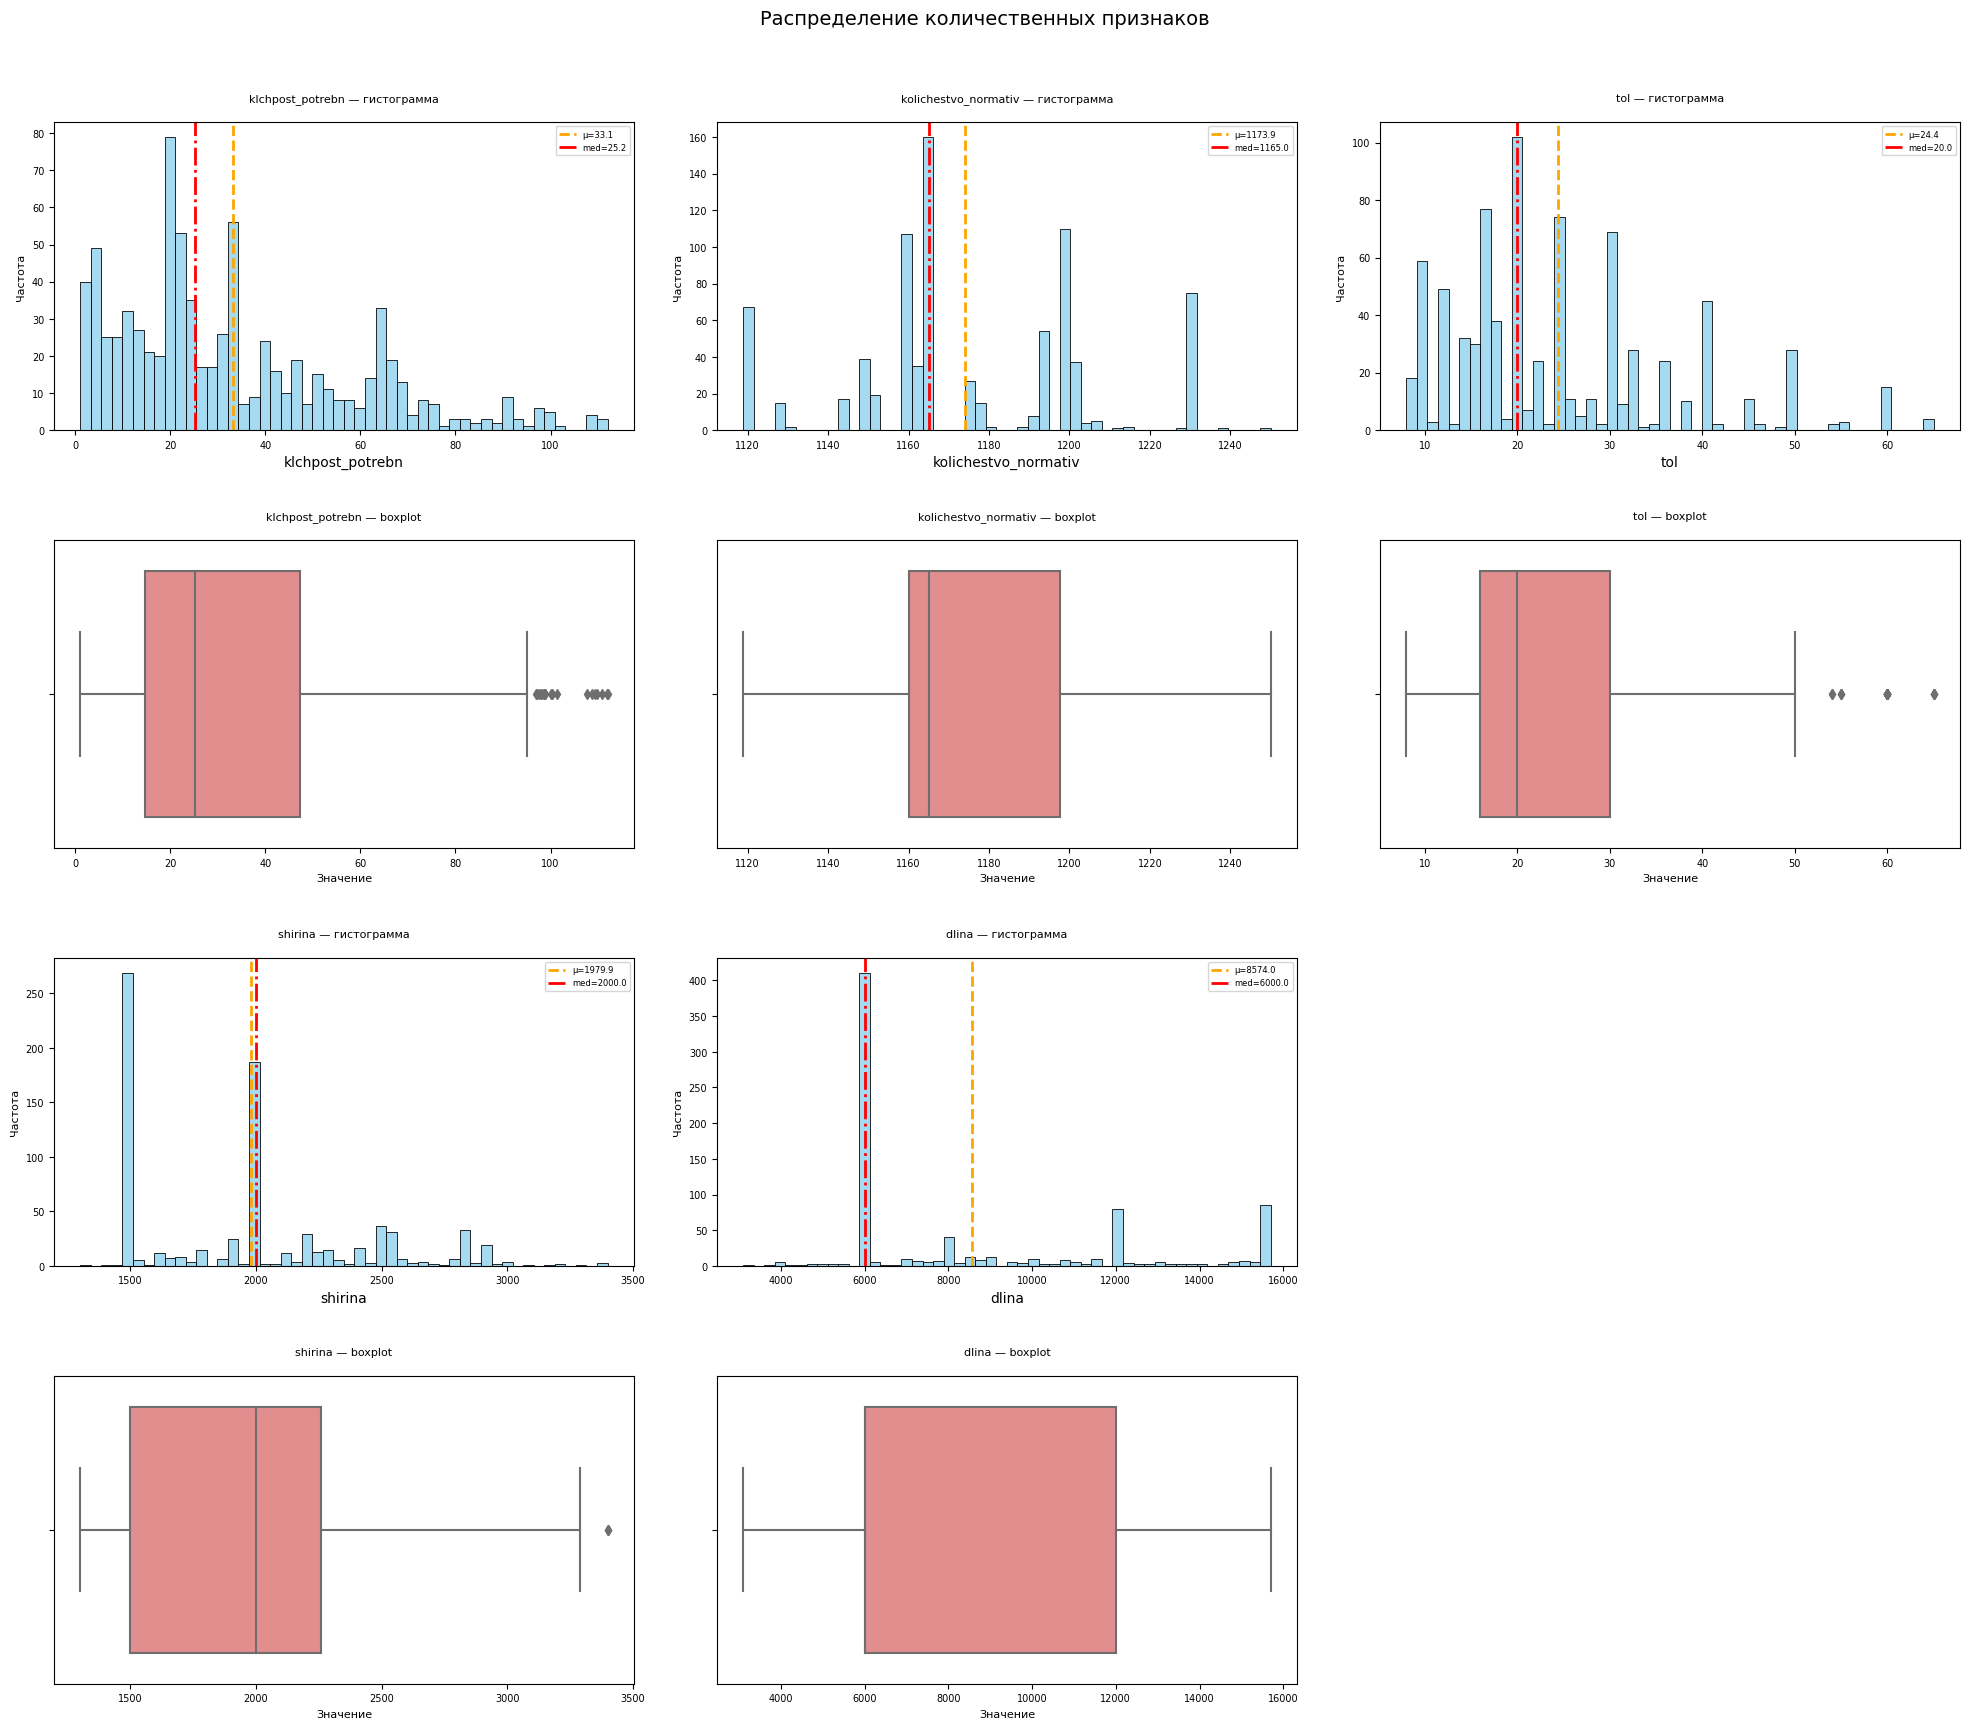

In [19]:
plot_numeric_distributions(df_cleaned_pep8, num_cols)

**Вывод:**

- КлчПост/Потребн - распределение признака ассимметрично, с правым хвостом. Медианное значение = 25.2, среднее значение = 33.1.
- Количество (норматив) - имеет дискретное распределение, с 4-мя модами. Самая большая по кол-ву 1165, 3 другие моды имеют значения - 1120, 1200, 1230.
- Толщина - распределение признака ассимметрично, с правым хвостом. Медианное значение = 20, среднее значение = 24.4.
- Ширина распределена двумодально, первая мода = 1500, вторая = 2000. Среднее и медианное занчения близки median = 2000, mean = 1980.
- Длина имеет одномодальное распределение, с модой = 6000. Медианное значение = 6000, среднее значение = 8575.


### Категориальные данные

Строим графики для 4 категориальных признаков...


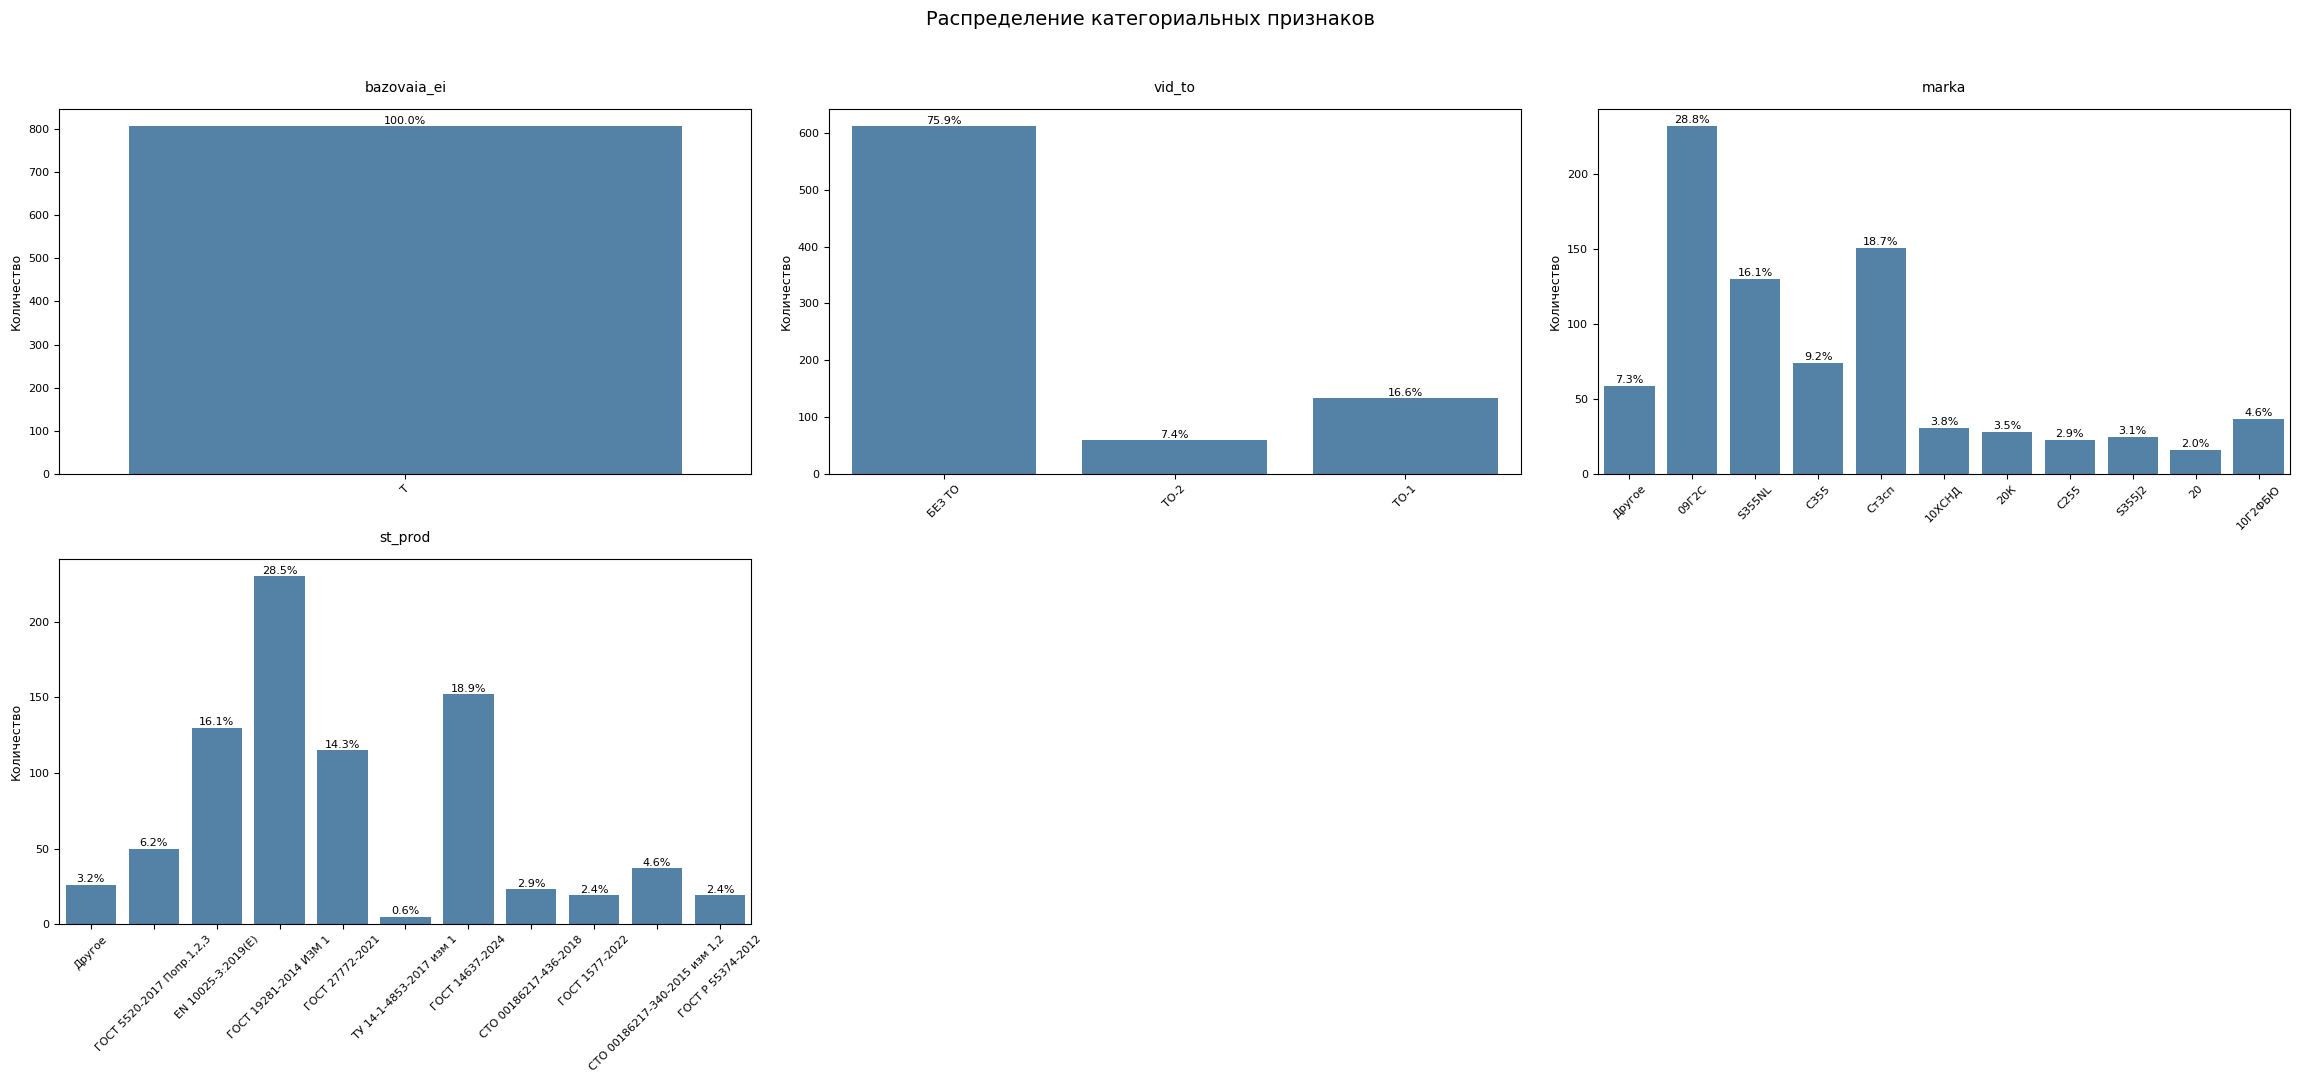

Графики категориальных признаков построены успешно!


In [20]:
plot_categorical_grid(df_cleaned_pep8, cat_cols)

**Вывод:**

- Признак `Базовая ЕИ` имеет дисперсию равную 0 (только одно значение), этот признак не несет информации для анализа и модели МО.
- У признака `VID_TO` самое часто встречающееся значение - `БЕЗ_ТО` ~ 75% всех наблюдений. ТО-1 ~ 16%, ТО-2 ~ 7%.
- Самая часто встречаемая `marka` 09Г2С.
- Самый популярный `st_prod` ГОСТ 19281-2014 ИЗМ 1.

Параметр bazovaia_ei имеет только одно занчение, эта колонка не имеет никакого информационного веса, поэтому удалим ее

In [21]:
df_cleaned_pep8 = delete_cat_with_zero_dispersion(df_cleaned_pep8, cat_cols)

Колонка 'bazovaia_ei' удалена: доля самого частого значения = 1.000
Удалено колонок: 1


### Анализ зависимости таргета с количественными признаками

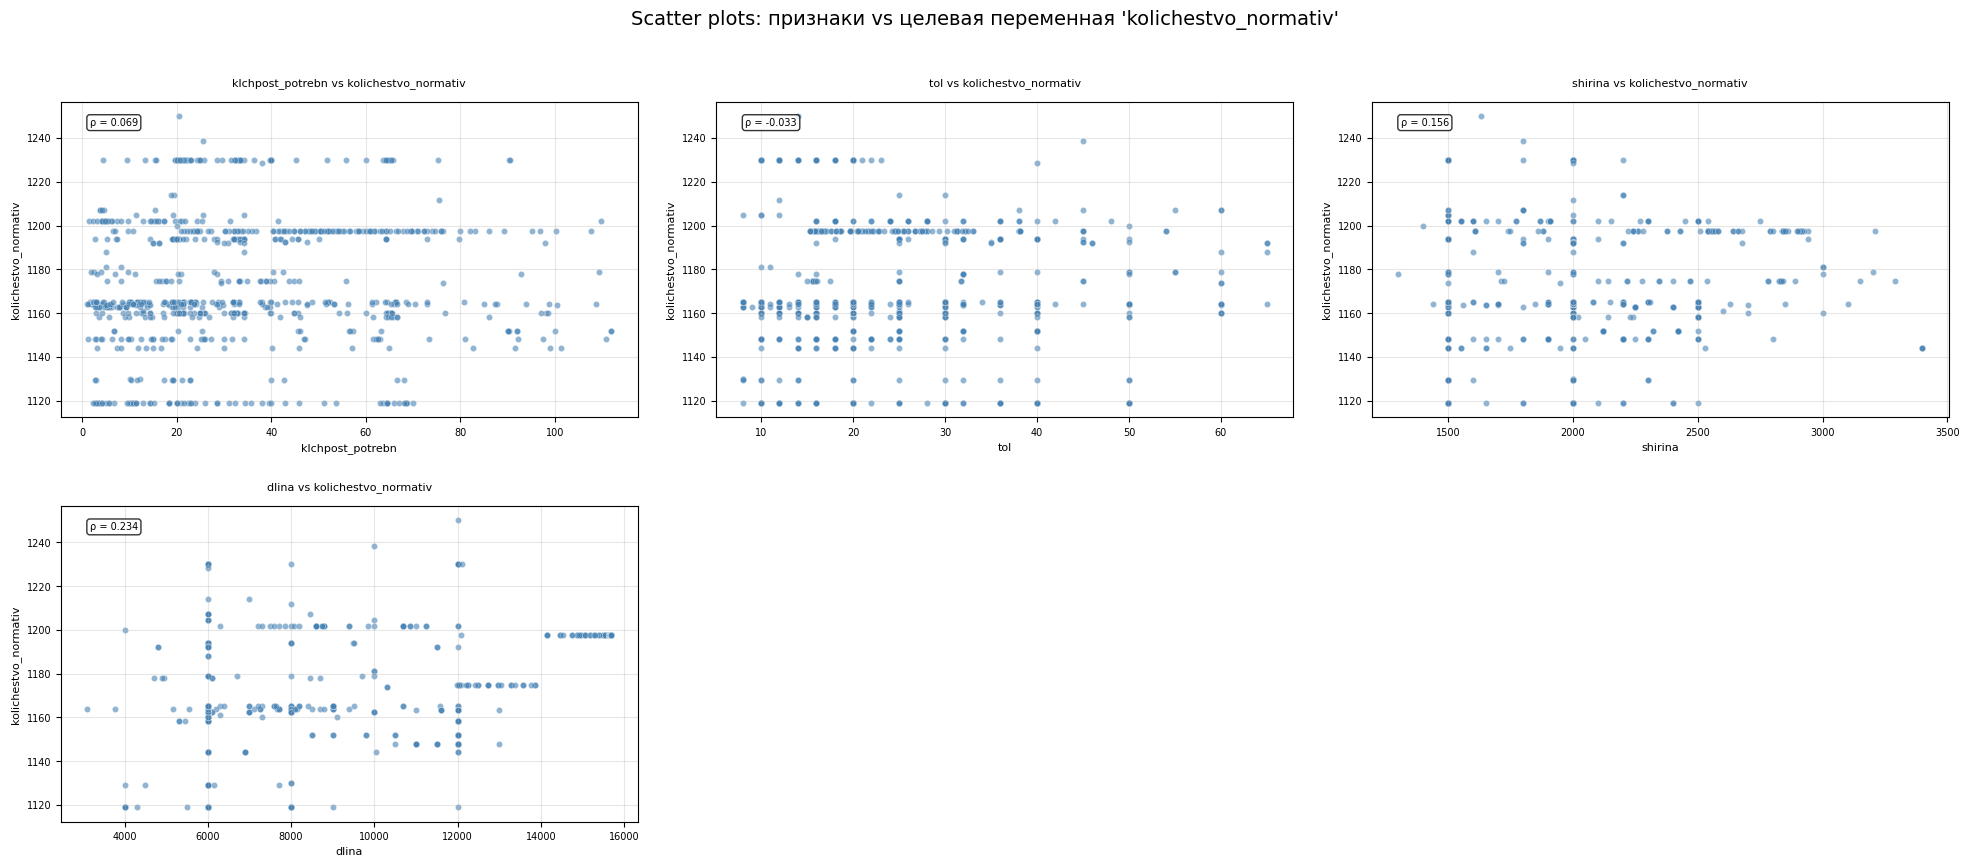

In [22]:
plot_target_scatter(
    df_cleaned_pep8, 
    target_column=TARGET, 
    feature_columns=[col for col in num_cols if col != TARGET]
)

**Вывод по исследовательскому анализу**

- Были проанализированы количественные и категориальные входные признаки.
- Был удален столбец `bazavoya_ei` с малой диспрерсией значений.

## Подготовка данных к обучению

In [23]:
num_cols = df_cleaned_pep8.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_cleaned_pep8.select_dtypes(include=['object', 'category']).columns.tolist()

In [24]:
display(num_cols, cat_cols, df_cleaned_pep8.columns)

['klchpost_potrebn', 'kolichestvo_normativ', 'tol', 'shirina', 'dlina']

['vid_to', 'marka', 'st_prod']

Index(['klchpost_potrebn', 'kolichestvo_normativ', 'tol', 'shirina', 'dlina',
       'vid_to', 'marka', 'st_prod'],
      dtype='object')

In [25]:
# Label Encoding с явным указанием что это категории
print(f"Размерность до обработки: {df_cleaned_pep8.shape}")

df_encoded = df_cleaned_pep8.copy()

# Применяем LabelEncoder к каждой категориальной колонке
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Теперь все признаки числовые
all_features = num_cols + cat_cols

# Масштабируем все признаки
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), all_features)
    ])

X_processed = preprocessor.fit_transform(df_encoded)

print(f"Размерность после обработки: {X_processed.shape}")
print(f"Использовано признаков: {len(all_features)}")

Размерность до обработки: (806, 8)
Размерность после обработки: (806, 8)
Использовано признаков: 8


## Обучение модели

### Группировка входных признаков

Вычисление матрицы связей...
Построение дендрограммы...
Реальные названия признаков:
Feature_0 -> klchpost_potrebn
Feature_1 -> kolichestvo_normativ
Feature_2 -> tol
Feature_3 -> shirina
Feature_4 -> dlina
Feature_5 -> vid_to
Feature_6 -> marka
Feature_7 -> st_prod


<Figure size 1600x1000 with 0 Axes>

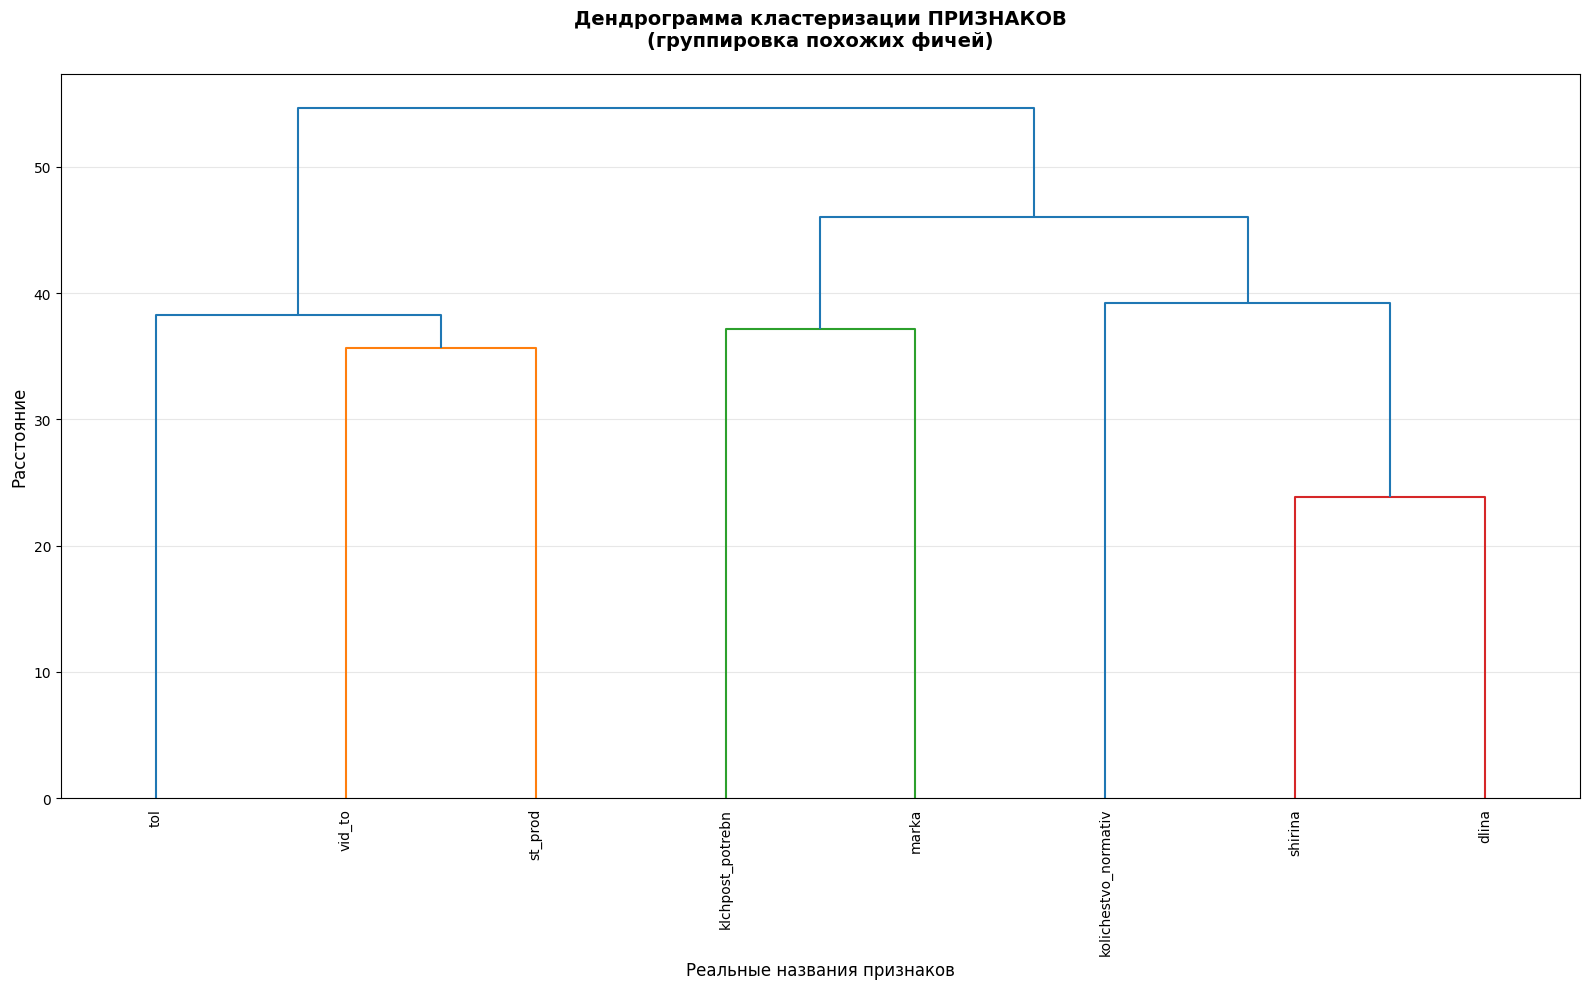

In [26]:
print("Вычисление матрицы связей...")
Z = linkage(X_processed, method='ward', metric='euclidean')

# Получаем названия признаков (предполагая, что X_processed - DataFrame)
if hasattr(X_processed, 'columns'):
    feature_names = X_processed.columns.tolist()
else:
    # Если это не DataFrame, создаем простые числовые метки
    feature_names = [f'Feature_{i}' for i in range(X_processed.shape[1])]

# Создаем подписи для каждого наблюдения
# Для дендрограммы обычно показывают индексы наблюдений, но можно адаптировать
labels = [f"Obs_{i}" for i in range(len(X_processed))]

# Построение дендрограммы
print("Построение дендрограммы...")

plt.figure(figsize=(16, 10))

# У вас уже есть список всех признаков
real_feature_names = all_features
print("Реальные названия признаков:")
for i, feature in enumerate(real_feature_names):
    print(f"Feature_{i} -> {feature}")

# Построение дендрограммы с реальными названиями
Z_features = linkage(X_processed.T, method='ward', metric='euclidean')

plt.figure(figsize=(16, 10))
dendrogram(Z_features,
           labels=real_feature_names,  # Используем реальные названия
           leaf_rotation=90,
           leaf_font_size=10,
           show_contracted=True,
           color_threshold=0.7 * max(Z_features[:, 2]))

plt.title('Дендрограмма кластеризации ПРИЗНАКОВ\n(группировка похожих фичей)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Реальные названия признаков', fontsize=12)
plt.ylabel('Расстояние', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Из дендограммы видно, что есть 5 групп входных признаков:

1. `tol`;
2. `vid_to` и `st_prod`;
3. `klchpost_potrebn` и `MARKA`;
4. `shirina` и `dlina`

И целевой признак `kolichestvo_normativ`

### Построение модели иерархической кластеризации


=== ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ ===
Вычисление матрицы связей (Ward + Euclidean)...

=== АНАЛИЗ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ ===
Вычисление инерции для разного числа кластеров...
Кластеров: 2, Инерция: 5148.50
Кластеров: 3, Инерция: 4181.30
Кластеров: 4, Инерция: 3678.06
Кластеров: 5, Инерция: 3308.22
Кластеров: 6, Инерция: 3002.55
Кластеров: 7, Инерция: 2730.03
Кластеров: 8, Инерция: 2513.04
Кластеров: 9, Инерция: 2334.06
Кластеров: 10, Инерция: 2224.88
Кластеров: 11, Инерция: 2122.73
Кластеров: 12, Инерция: 2024.41
Кластеров: 13, Инерция: 1927.30
Кластеров: 14, Инерция: 1834.97
Кластеров: 15, Инерция: 1754.80
Кластеров: 16, Инерция: 1690.68
Кластеров: 17, Инерция: 1631.42
Кластеров: 18, Инерция: 1575.12
Кластеров: 19, Инерция: 1527.69
🎯 Автоматически найденный elbow point: 3 кластеров

=== СОЗДАНИЕ ФИНАЛЬНЫХ КЛАСТЕРОВ ===
✅ Создано 3 кластеров (на основе elbow point)
Распределение по кластерам:
1    141
2    287
3    378
Name: Cluster, dtype: int64

📊 АНАЛИЗ КАЧЕСТВА КЛАСТЕРИЗАЦИИ:


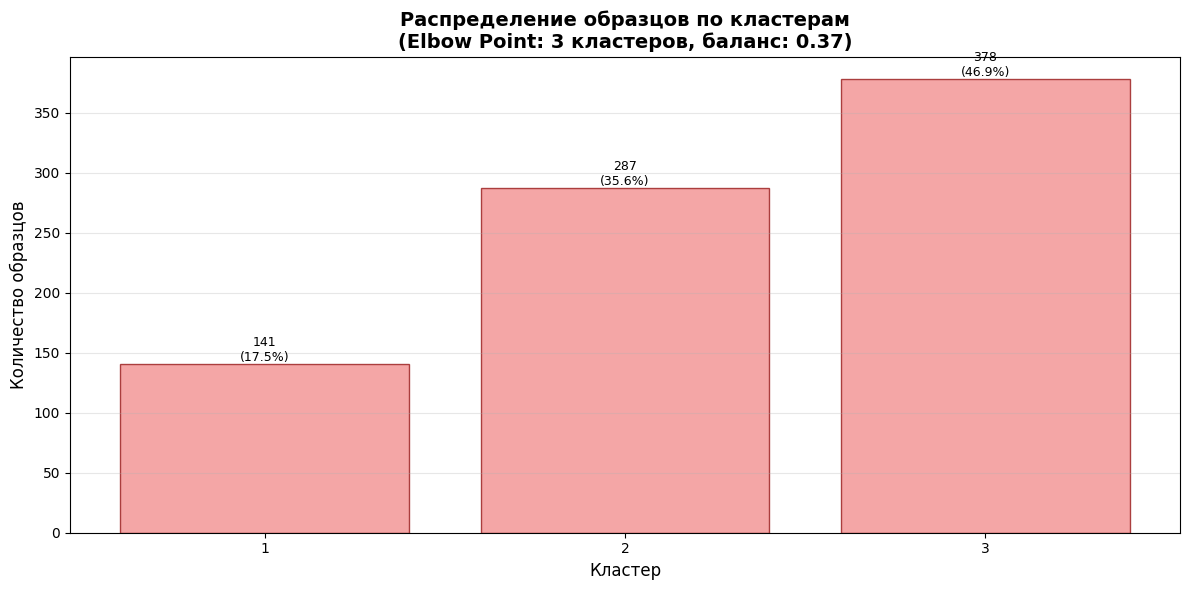


=== АНАЛИЗ КЛАСТЕРОВ ===
📈 СТАТИСТИКА ЧИСЛОВЫХ ПРИЗНАКОВ ПО КЛАСТЕРАМ:


klchpost_potrebn        kolichestvo_normativ           tol         \
                    mean    std                 mean    std   mean    std   
Cluster                                                                     
1                  47.18  20.99              1192.77   9.66  24.30   9.07   
2                  32.19  26.17              1149.93  20.30  26.41  14.17   
3                  28.49  22.83              1185.12  28.79  22.83  10.98   

         shirina             dlina           
            mean     std      mean      std  
Cluster                                      
1        2604.05  346.45  14592.82  1976.62  
2        1752.11  301.49   7324.69  2401.33  
3        1920.12  386.73   7277.43  2007.59

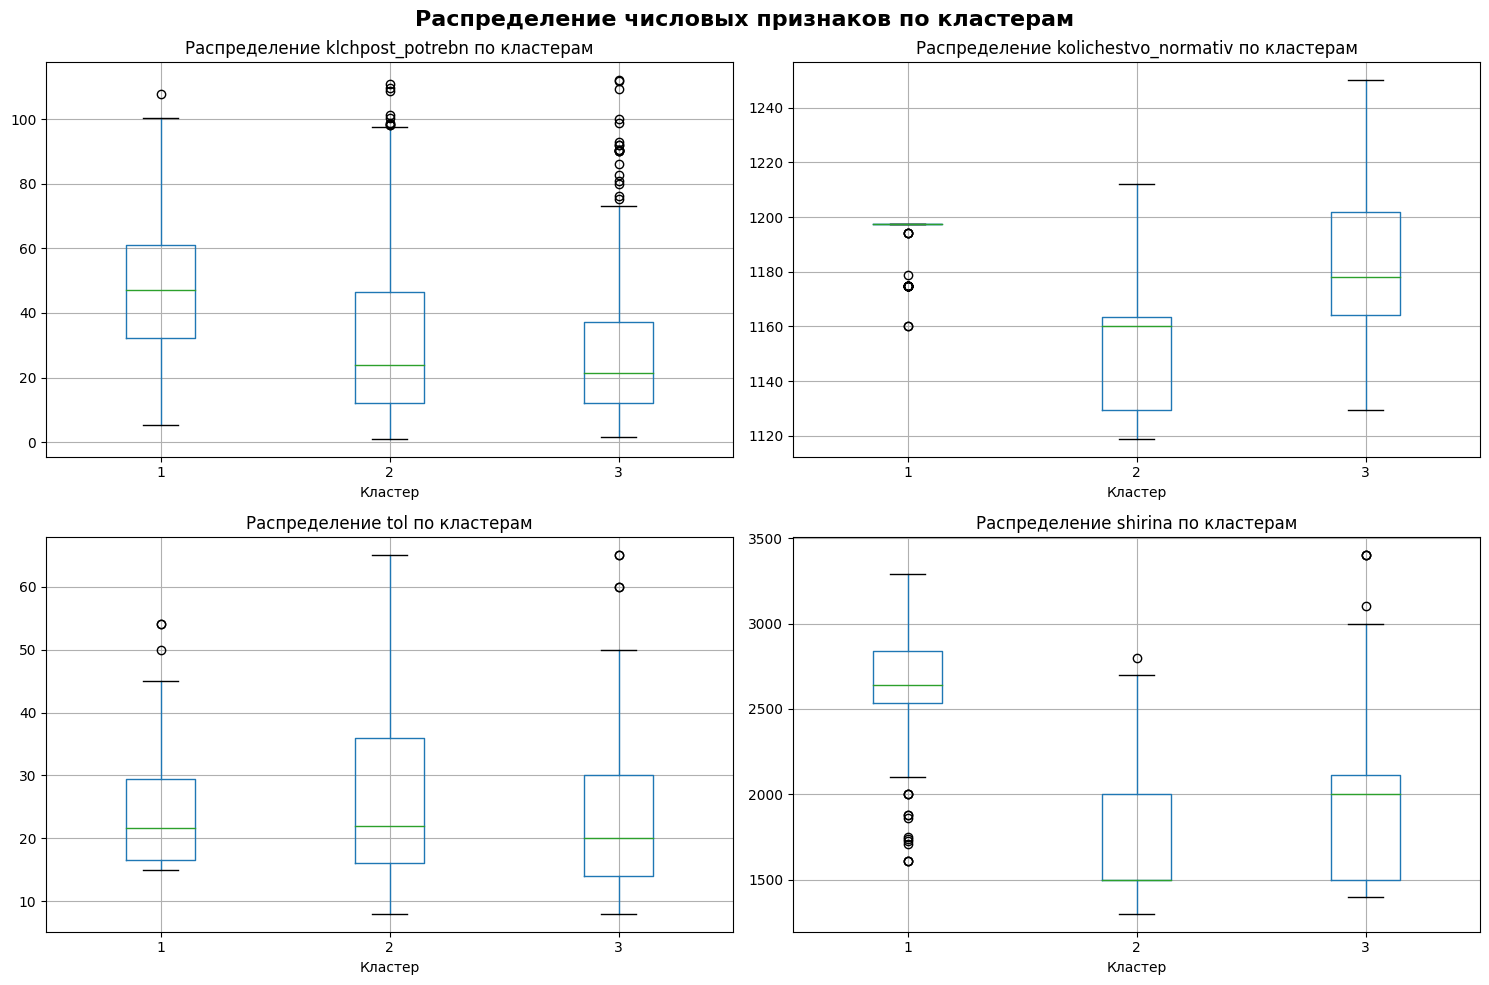


📊 РАСПРЕДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ПО КЛАСТЕРАМ:

🔹 VID_TO:
--------------------------------------------------


vid_to,БЕЗ ТО,ТО-1,ТО-2
Cluster,,,
1,100.0%,0.0%,0.0%
2,81.2%,18.5%,0.3%
3,63.0%,21.4%,15.6%



📈 ДОМИНИРУЮЩИЕ КАТЕГОРИИ:
   Кластер 1: БЕЗ ТО (100.0%)
   Кластер 2: БЕЗ ТО (81.2%)
   Кластер 3: БЕЗ ТО (63.0%), ТО-1 (21.4%)

🔹 MARKA:
--------------------------------------------------


marka,09Г2С,S355NL,С355,Ст3сп
Cluster,,,,
1,0.0%,92.2%,0.0%,2.1%
2,4.2%,0.0%,24.7%,51.6%
3,58.2%,0.0%,0.8%,0.0%



📈 ДОМИНИРУЮЩИЕ КАТЕГОРИИ:
   Кластер 1: S355NL (92.2%)
   Кластер 2: С355 (24.7%), Ст3сп (51.6%)
   Кластер 3: 09Г2С (58.2%)

🔹 ST_PROD:
--------------------------------------------------


st_prod,EN 10025-3:2019(Е),ГОСТ 14637-2024,ГОСТ 19281-2014 ИЗМ 1,ГОСТ 27772-2021,"ГОСТ 5520-2017 Попр.1,2,3"
Cluster,,,,,
1,92.2%,2.1%,0.0%,0.0%,0.0%
2,0.0%,51.9%,3.8%,36.9%,1.7%
3,0.0%,0.0%,57.9%,2.4%,11.9%



📈 ДОМИНИРУЮЩИЕ КАТЕГОРИИ:
   Кластер 1: EN 10025-3:2019(Е) (92.2%)
   Кластер 2: ГОСТ 14637-2024 (51.9%), ГОСТ 27772-2021 (36.9%)
   Кластер 3: ГОСТ 19281-2014 ИЗМ 1 (57.9%)

=== ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ ===


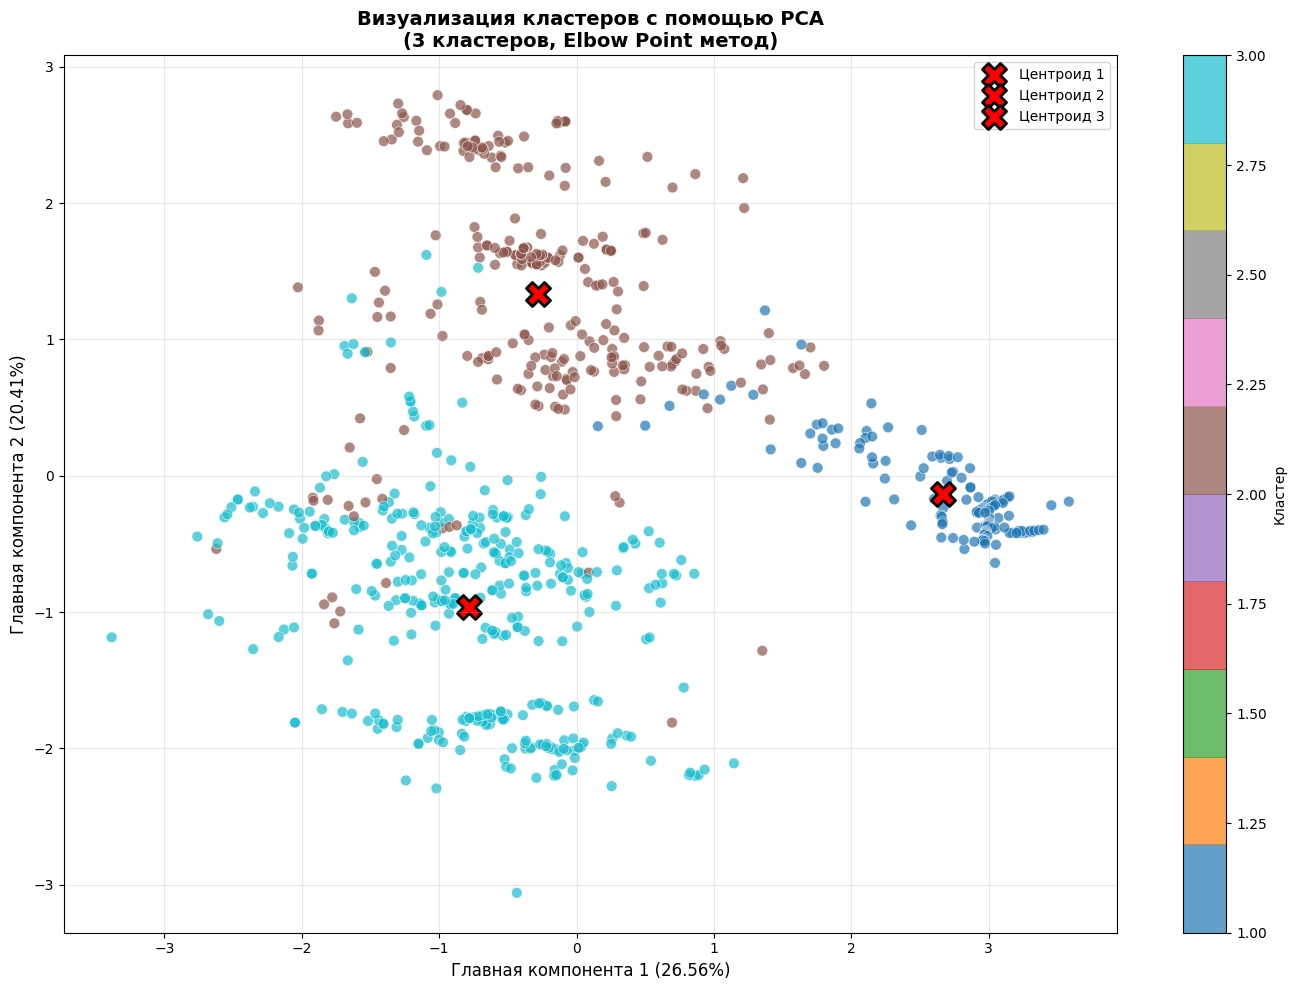


🎯 ФИНАЛЬНАЯ СТАТИСТИКА КЛАСТЕРИЗАЦИИ
🔢 Количество кластеров: 3 (Elbow Point)
📐 Метод кластеризации: Ward
📏 Метрика расстояния: Euclidean

💾 Результаты сохранены в файл: 'clustered_data_ward_euclidean_3clusters_elbow.xlsx'

✅ КЛАСТЕРИЗАЦИЯ УСПЕШНО ЗАВЕРШЕНА!
🎯 Использовано оптимальное число кластеров: 3 (Elbow Point)


In [ ]:
# Иерархическая кластеризация (только Ward + Euclidean)
print("\n=== ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ ===")

# Вычисляем матрицу связей (только Ward + Euclidean)
print("Вычисление матрицы связей (Ward + Euclidean)...")
Z = linkage(X_processed, method='ward', metric='euclidean')

# Анализ оптимального числа кластеров
print("\n=== АНАЛИЗ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ ===")

# Функция для вычисления инерции (суммы квадратов расстояний)
def calculate_inertia(Z, n_clusters):
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    inertia = 0
    for i in range(1, n_clusters + 1):
        cluster_points = X_processed[clusters == i]
        if len(cluster_points) > 0:
            centroid = cluster_points.mean(axis=0)
            inertia += np.sum((cluster_points - centroid) ** 2)
    return inertia

# Вычисляем инерцию для разного числа кластеров
inertias = []
cluster_range = range(2, 20)

print("Вычисление инерции для разного числа кластеров...")
for k in cluster_range:
    inertia = calculate_inertia(Z, k)
    inertias.append(inertia)
    print(f"Кластеров: {k}, Инерция: {inertia:.2f}")

# Функция для автоматического нахождения elbow point
def find_elbow_point(inertias, cluster_range):
    """
    Автоматически находит точку "локтя" на графике инерции
    """
    # Вычисляем вторые производные (изменения изменений)
    first_diff = np.diff(inertias)
    second_diff = np.diff(first_diff)
    
    # Находим точку максимального изгиба
    elbow_idx = np.argmax(np.abs(second_diff)) + 1  # +1 из-за diff
    
    return list(cluster_range)[elbow_idx]

# Находим "локоть" автоматически
elbow_point = find_elbow_point(inertias, cluster_range)

print(f"🎯 Автоматически найденный elbow point: {elbow_point} кластеров")

# Создание финальных кластеров
print("\n=== СОЗДАНИЕ ФИНАЛЬНЫХ КЛАСТЕРОВ ===")

# ИСПОЛЬЗУЕМ АВТОМАТИЧЕСКИ НАЙДЕННЫЙ ELBOW POINT
optimal_clusters = elbow_point
df_cleaned_pep8['Cluster'] = fcluster(Z, optimal_clusters, criterion='maxclust')

print(f"✅ Создано {optimal_clusters} кластеров (на основе elbow point)")
print("Распределение по кластерам:")
cluster_distribution = df_cleaned_pep8['Cluster'].value_counts().sort_index()
print(cluster_distribution)

# Анализ качества кластеризации
print(f"\n📊 АНАЛИЗ КАЧЕСТВА КЛАСТЕРИЗАЦИИ:")
total_samples = len(df_cleaned_pep8)
for cluster, count in cluster_distribution.items():
    percentage = (count / total_samples) * 100
    print(f"Кластер {cluster}: {count} образцов ({percentage:.1f}%)")

# Проверяем баланс кластеров
min_cluster_size = cluster_distribution.min()
max_cluster_size = cluster_distribution.max()
balance_ratio = min_cluster_size / max_cluster_size

print(f"\n⚖️  Баланс кластеров: {balance_ratio:.2f}")
if balance_ratio > 0.3:
    print("✅ Хорошо сбалансированные кластеры")
elif balance_ratio > 0.1:
    print("⚠️  Умеренно сбалансированные кластеры")
else:
    print("❌ Несбалансированные кластеры - рассмотрите другое число кластеров")

# Визуализация распределения кластеров
plt.figure(figsize=(12, 6))

# Столбчатая диаграмма
bars = plt.bar(cluster_distribution.index, cluster_distribution.values, 
               color='lightcoral', edgecolor='darkred', alpha=0.7)

# Добавляем подписи с количеством и процентом
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_samples) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontsize=9)

plt.xlabel('Кластер', fontsize=12)
plt.ylabel('Количество образцов', fontsize=12)
plt.title(f'Распределение образцов по кластерам\n(Elbow Point: {optimal_clusters} кластеров, баланс: {balance_ratio:.2f})', 
          fontsize=14, fontweight='bold')
plt.xticks(range(1, optimal_clusters + 1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ характеристик кластеров
print("\n=== АНАЛИЗ КЛАСТЕРОВ ===")

# Анализ числовых признаков по кластерам
print("📈 СТАТИСТИКА ЧИСЛОВЫХ ПРИЗНАКОВ ПО КЛАСТЕРАМ:")
numeric_summary = df_cleaned_pep8.groupby('Cluster')[num_cols].agg(['mean', 'std'])
display(numeric_summary.round(2))

# Визуализация числовых признаков по кластерам
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    if i < len(axes):
        df_cleaned_pep8.boxplot(column=col, by='Cluster', ax=axes[i])
        axes[i].set_title(f'Распределение {col} по кластерам')
        axes[i].set_xlabel('Кластер')

plt.suptitle('Распределение числовых признаков по кластерам', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Анализ категориальных признаков по кластерам
print("\n📊 РАСПРЕДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ПО КЛАСТЕРАМ:")
print("="*80)

for cat_feature in cat_cols:
    print(f"\n🔹 {cat_feature.upper()}:")
    print("-" * 50)
    
    cross_tab = pd.crosstab(df_cleaned_pep8['Cluster'], df_cleaned_pep8[cat_feature], 
                           normalize='index') * 100
    
    # Показываем только значения > 10%
    significant_values = cross_tab.loc[:, (cross_tab > 10).any()]
    
    if not significant_values.empty:
        # Стилизуем таблицу
        styled_table = significant_values.round(1).style \
            .set_caption(f'Распределение {cat_feature} по кластерам (%)') \
            .set_table_styles([
                {'selector': 'caption', 'props': [('font-size', '14px'), 
                                                ('font-weight', 'bold'),
                                                ('margin-bottom', '10px')]},
                {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                           ('font-weight', 'bold'),
                                           ('text-align', 'center')]},
                {'selector': 'td', 'props': [('text-align', 'center')]}
            ]) \
            .background_gradient(cmap='Blues', axis=0) \
            .format('{:.1f}%')
        
        display(styled_table)
        
        # Текстовый анализ доминирующих категорий
        print("\n📈 ДОМИНИРУЮЩИЕ КАТЕГОРИИ:")
        for cluster in significant_values.index:
            dominant_cats = significant_values.loc[cluster][significant_values.loc[cluster] > 20]
            if not dominant_cats.empty:
                dominant_str = ", ".join([f"{cat} ({percent:.1f}%)" 
                                        for cat, percent in dominant_cats.items()])
                print(f"   Кластер {cluster}: {dominant_str}")
                
    else:
        print("❌ Нет доминирующих категорий (>10%)")
    
    print("="*80)

# Визуализация кластеров с помощью PCA
print("\n=== ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ ===")

# PCA для визуализации в 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(14, 10))

# Точечная диаграмма кластеров
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=df_cleaned_pep8['Cluster'], 
                     cmap='tab10', 
                     alpha=0.7,
                     s=60,
                     edgecolors='w',
                     linewidth=0.5)

plt.colorbar(scatter, label='Кластер')
plt.title(f'Визуализация кластеров с помощью PCA\n({optimal_clusters} кластеров, Elbow Point метод)', 
          fontsize=14, fontweight='bold')
plt.xlabel(f'Главная компонента 1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Главная компонента 2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.grid(alpha=0.3)

# Добавляем центроиды кластеров
for cluster in range(1, optimal_clusters + 1):
    cluster_points = X_pca[df_cleaned_pep8['Cluster'] == cluster]
    if len(cluster_points) > 0:
        centroid = cluster_points.mean(axis=0)
        plt.scatter(centroid[0], centroid[1], 
                   marker='X', s=300, c='red', 
                   edgecolors='black', linewidth=2,
                   label=f'Центроид {cluster}')

plt.legend()
plt.tight_layout()
plt.show()

# 10. Финальная статистика
print("\n" + "="*60)
print("🎯 ФИНАЛЬНАЯ СТАТИСТИКА КЛАСТЕРИЗАЦИИ")
print("="*60)
print(f"🔢 Количество кластеров: {optimal_clusters} (Elbow Point)")
print(f"📐 Метод кластеризации: Ward")
print(f"📏 Метрика расстояния: Euclidean")


# Сохраняем результаты
output_filename = f'clustered_data_ward_euclidean_{optimal_clusters}clusters_elbow.xlsx'
df_cleaned_pep8.to_excel(output_filename, index=False)
print(f"\n💾 Результаты сохранены в файл: '{output_filename}'")

print(f"\n✅ КЛАСТЕРИЗАЦИЯ УСПЕШНО ЗАВЕРШЕНА!")
print(f"🎯 Использовано оптимальное число кластеров: {optimal_clusters} (Elbow Point)")

**Вывод**

- Методом логтя, было определено оптимальное количество кластеров (3 кластера).
- Они распределены:  
    Кластер 1: 141 образцов (17.5%)   
    Кластер 2: 287 образцов (35.6%)   
    Кластер 3: 378 образцов (46.9%)  

## Анализ построенной кластеризации с помощью Дерева решений

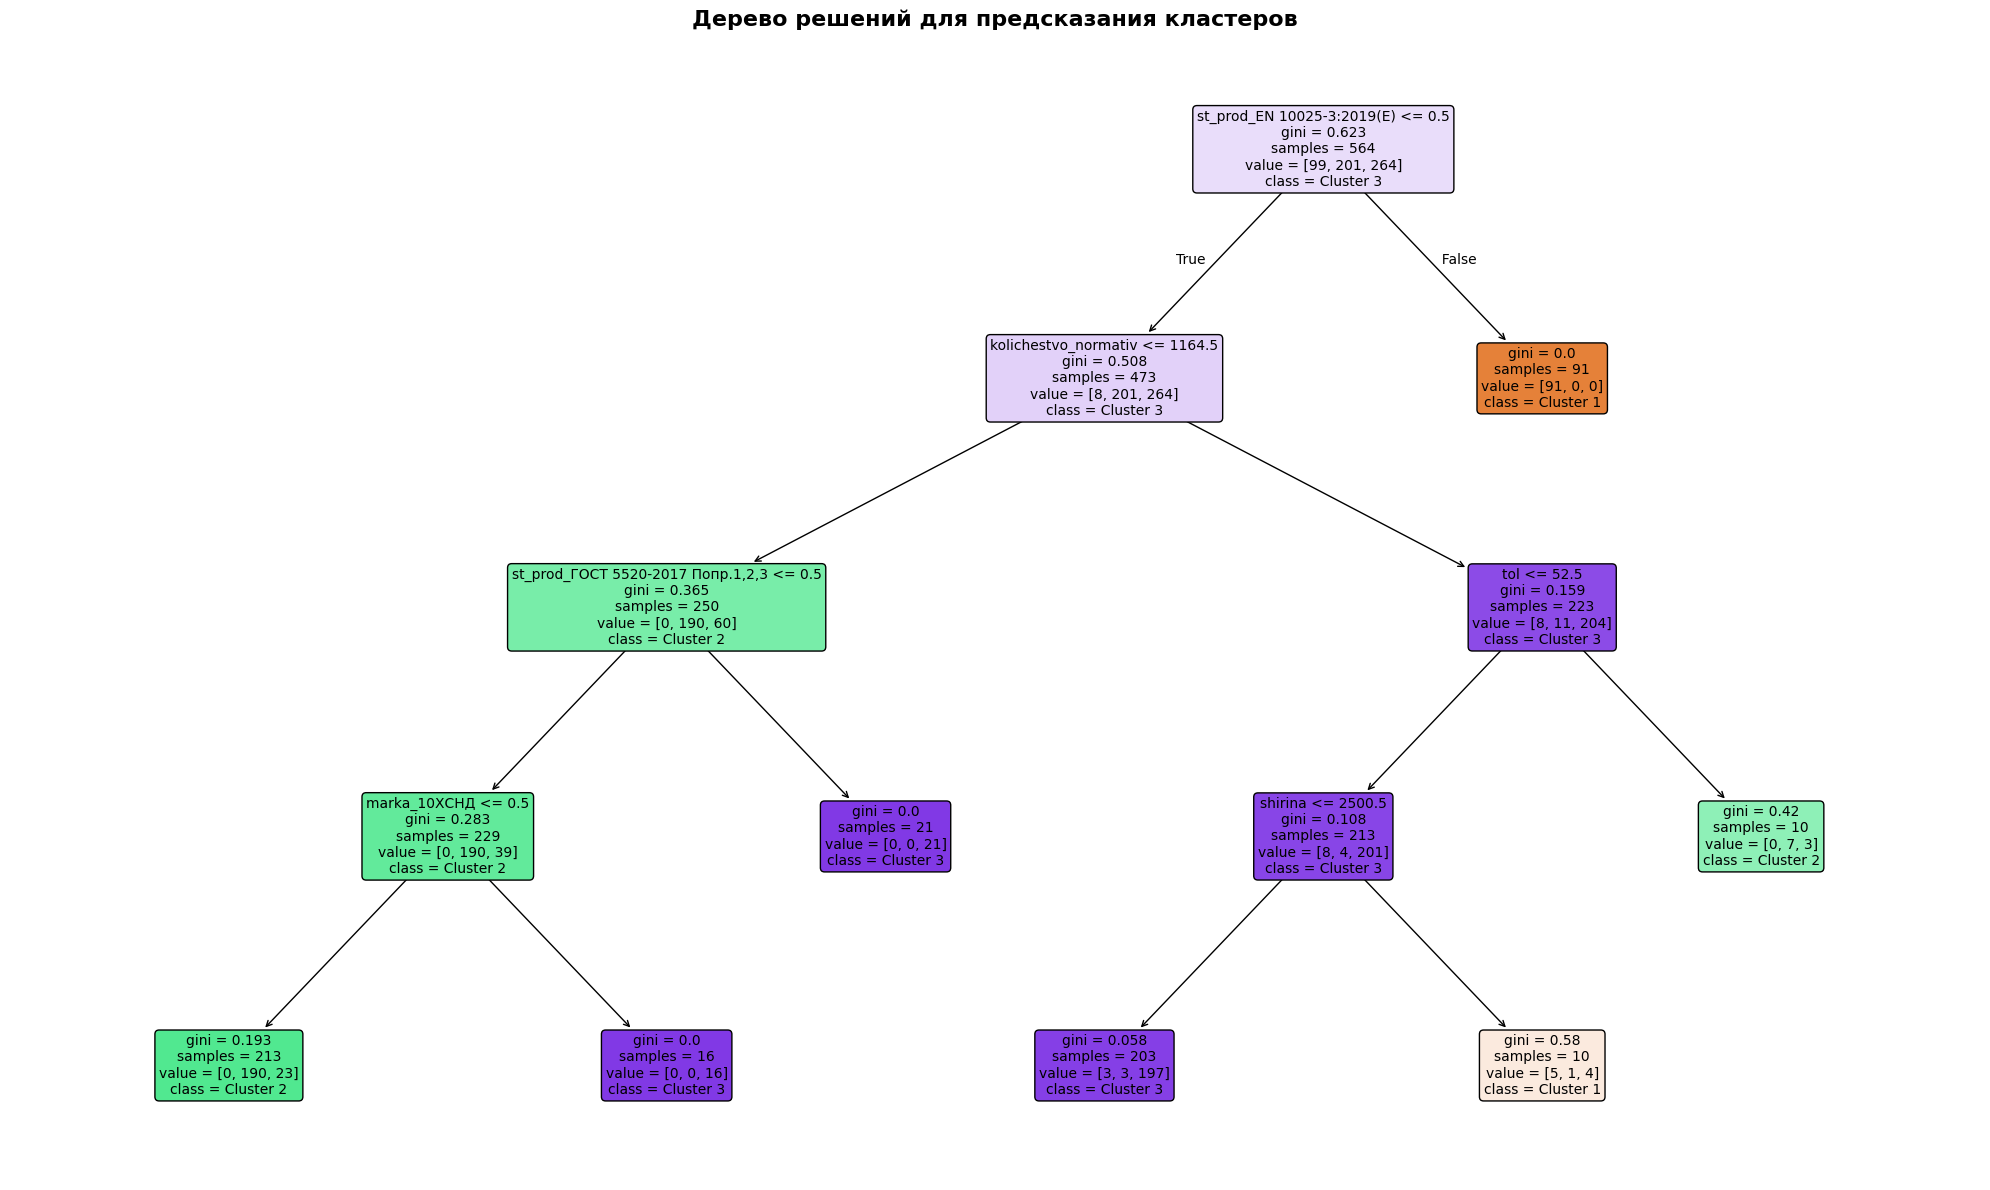

Важность признаков для определения кластеров:
                              feature  importance
1                kolichestvo_normativ    0.392692
37         st_prod_EN 10025-3:2019(Е)    0.385637
43  st_prod_ГОСТ 5520-2017 Попр.1,2,3    0.091751
9                        marka_10ХСНД    0.082049
2                                 tol    0.029112
3                             shirina    0.018758
0                    klchpost_potrebn    0.000000
41      st_prod_ГОСТ 19281-2014 ИЗМ 1    0.000000
32                        marka_С390П    0.000000
33                         marka_С590    0.000000


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

# Подготовка данных для дерева
X_for_tree = df_cleaned_pep8[num_cols + cat_cols].copy()
y_clusters = df_cleaned_pep8['Cluster']

# One-Hot кодирование для категориальных признаков
X_encoded = pd.get_dummies(X_for_tree, columns=cat_cols, drop_first=True)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_clusters, test_size=0.3, random_state=42, stratify=y_clusters
)

# Обучаем дерево решений
tree_clf = DecisionTreeClassifier(
    max_depth=4,  
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

tree_clf.fit(X_train, y_train)

# Визуализация дерева
plt.figure(figsize=(20, 12))
plot_tree(tree_clf,
          feature_names=X_encoded.columns.tolist(),
          class_names=[f'Cluster {i}' for i in range(1, optimal_clusters+1)],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Дерево решений для предсказания кластеров', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': tree_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("Важность признаков для определения кластеров:")
print(feature_importance.head(10))

**Вывод**

Наиболее важные признаки для кластеризации - это `kolichestvo_normativ`,  `st_prod`.


## Общий вывод

1. Был загружен датасет по металлопродукции для проведения кластеризации:
    - датасет имеет 11 столбцов и 1162 строки;
    - в датасете отсутствуют пропуски и дубликаты;
    - названия столбцов не удволетворяют PEP8.
2. Была проведена предобработка данных в ходе которой:
    - удалены выбросы;
    - названия столбцов приведены к PEP8.
3. Был проведен исследовательский анализ данных.
4. Данные были подготовлены и закодированы для дальнейшей кластеризации методом МО.
5. Было определено оптимальное количество кластеров с помощью метода логтя (3 кластера).
6. Была проведена кластеризация данных и был сохранен новый датасет с этой кластеризацией.
7. Был проведен анализ кластеризации с помощью дерева решений и определены параметры имеющие наибольшее влияние при кластеризации целевой переменной.
